# 2. Denoising and Detoning

## 2.2 The Marcenko-Pastur Theorem


##### formulation to be constructed

### Snippet 2.1 The Marcenko-Pastur PDF


In [1]:
import numpy as np,pandas as pd


def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax = var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal = np.linspace(eMin,eMax,pts)
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf = pd.Series(pdf.flatten(),index=eVal.flatten())
    return pdf

### Snippet 2.2 The Marcenko-Pastur PDF


In [2]:
from sklearn.neighbors import KernelDensity

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec


def fitKDE(obs,bWidth=.25,kernel="gaussian",x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde = KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb = kde.score_samples(x) # log(density)
    pdf = pd.Series(np.exp(logProb),index=x.flatten())
    return pdf


x = np.random.normal(size=(10000,1000))
eVal0,eVec0 = getPCA(np.corrcoef(x,rowvar=0))
pdf0 = mpPDF(1.,q=x.shape[0]/float(x.shape[1]),pts=1000)
pdf1 = fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf
        
        
    
    

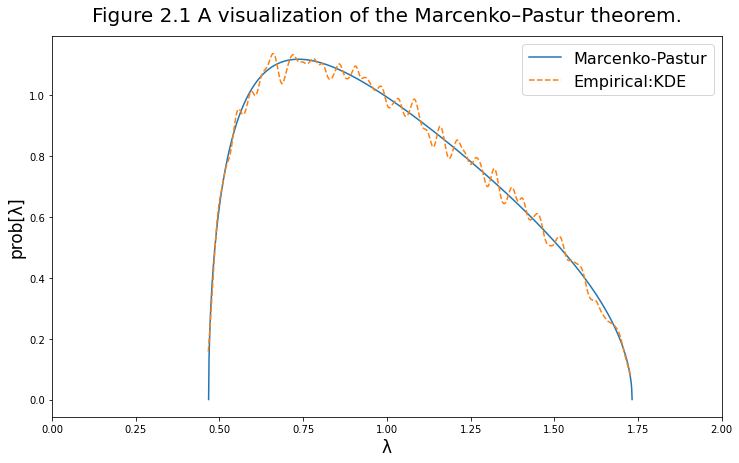

In [3]:
# plot_function

def plot_pdf(pdf0, pdf1, x_max,title="",label0="", label1="", xlabel="", ylabel=""):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,7))
    plt.plot(pdf0, label=label0)
    plt.plot(pdf1, "--", label=label1)
    plt.xlim(0,x_max)
    plt.title(title, fontsize=20, pad=15)
    plt.legend(fontsize=16)
    plt.xlabel(xlabel, fontsize=17)
    plt.ylabel(ylabel, fontsize=17)
    plt.show()

plot_pdf(pdf0, pdf1, 2.0, 
         title="Figure 2.1 A visualization of the Marcenko–Pastur theorem.",
        label0="Marcenko-Pastur",
        label1="Empirical:KDE",
        xlabel="λ",
        ylabel="prob[λ]")

### Snippet 2.3 Add Signal To a Random Covariance Matrix


In [4]:
def getRndCov(nCols,nFacts):
    w = np.random.normal(size=(nCols,nFacts))
    cov = np.dot(w,w.T) # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) # full rank cov
    return cov


def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1] = -1,1 # numerical error
    return corr


alpha,nCols,nFact,q = .995,1000,100,10
cov = np.cov(np.random.normal(size=(nCols*q,nCols)),rowvar=0)
cov = alpha*cov+(1-alpha)*getRndCov(nCols,nFact) # noise+signal
corr0 = cov2corr(cov)
eVal0,eVec0 = getPCA(corr0)

### Snippet 2.4 Fitting the Marcenko-Pastur PDF


In [5]:
from scipy.optimize import minimize

def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0 = mpPDF(var,q,pts) # theoretical pdf
    pdf1 = fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    return sse

def findMaxEval(eVal,q,bWidth):

    out = minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth), bounds=((1E-5,1-1E-5),))
    if out['success']:var=out['x'][0]
    else:var = 1
    eMax = var*(1+(1./q)**.5)**2
    return eMax,var

eMax0,var0 = findMaxEval(np.diag(eVal0),q,bWidth=.01)
nFacts0 = eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

pdf1 = fitKDE(np.diag(eVal0),bWidth=.003) # empirical pdf
pdf0 = mpPDF(var0,q=x.shape[0]/float(x.shape[1]),pts=1000)
pdf_noise = pdf1.loc[:eMax0]
pdf_signal = pdf1.loc[eMax0:]

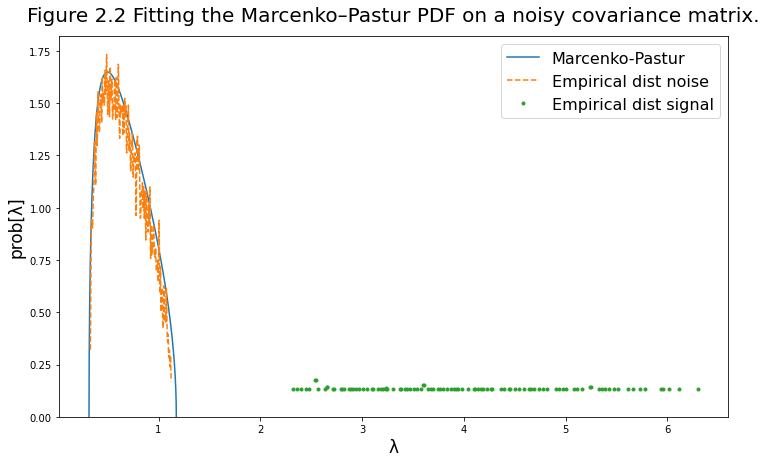

In [14]:
# plot_function

def plot_pdf_ns(pdf0, pdf1_noise, pdf1_signal , x_max,y_min, title="",label0="", label1="", label2="", xlabel="", ylabel=""):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,7))
    plt.plot(pdf0, label=label0)
    plt.plot(pdf1_noise, "--", label=label1)
    plt.plot(pdf1_signal, ".", label=label2)
#     plt.xlim(0,x_max)
    plt.ylim(0)
    plt.title(title, fontsize=20, pad=15)
    plt.legend(fontsize=16)
    plt.xlabel(xlabel, fontsize=17)
    plt.ylabel(ylabel, fontsize=17)
    plt.show()

plot_pdf_ns(pdf0, pdf_noise, pdf_signal, 2.0, 0,  
        title="Figure 2.2 Fitting the Marcenko–Pastur PDF on a noisy covariance matrix.",
        label0="Marcenko-Pastur",
        label1="Empirical dist noise",
        label2="Empirical dist signal",
        xlabel="λ",
        ylabel="prob[λ]")

### Snippet 2.5 Denoising by Constant Residual Eigenvalue


In [18]:
def denoiseCorr(eVal, eVec, nFacts):
    # remove noise from corr
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_ = np.diag(eVal_)
    corr1 = np.dot(eVec, eVal_).dot(eVec.T)
    corr1 = cov2corr(corr1)
    return corr1

corr1 = denoiseCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)    

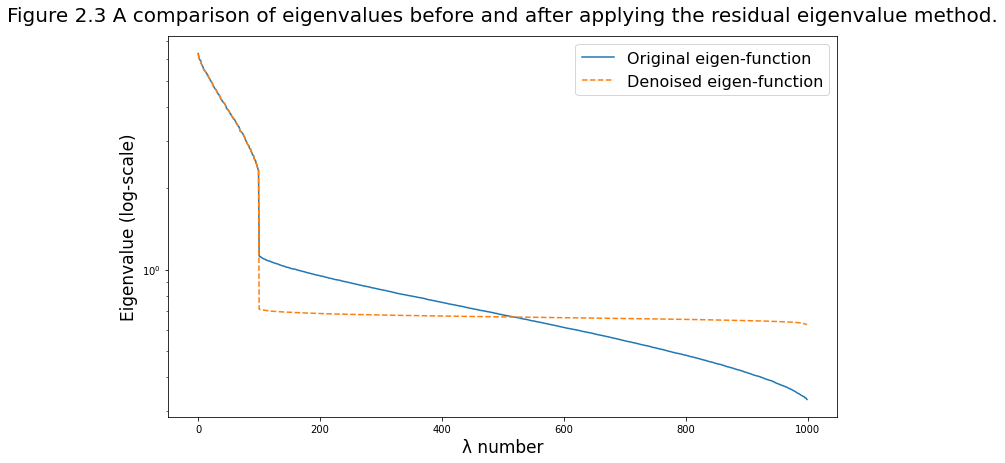

In [45]:
# plot_function

def plot_eigen(pdf0, pdf1, x_max,title="",label0="", label1="", xlabel="", ylabel=""):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,7))
    plt.yscale('log')
    plt.plot(pdf0, label=label0)
    plt.plot(pdf1, "--", label=label1)
#     plt.xlim(0,x_max)
    plt.title(title, fontsize=20, pad=15)
    plt.legend(fontsize=16)
    plt.xlabel(xlabel, fontsize=17)
    plt.ylabel(ylabel, fontsize=17)
    plt.show()

plot_eigen(np.diag(eVal0), np.diag(eVal1), 2.0, 
         title="Figure 2.3 A comparison of eigenvalues before and after applying the residual eigenvalue method.",
        label0="Original eigen-function",
        label1="Denoised eigen-function",
        xlabel="λ number",
        ylabel="Eigenvalue (log-scale)")

### Snippet 2.6 Denoising by Targeted Shrinkage


In [55]:
def denoisedCorr2(eVal, eVec, nFacts, alpha=0):
    #remove noise by shrinkage
    eValL, eVecL = eVal[:nFacts, :nFacts], eVec[:, :nFacts] 
    eValR, eVecR = eVal[nFacts:, nFacts:], eVec[:, nFacts:]
    corr0 = np.dot(eVecL, eValL).dot(eVecL.T)
    corr1 = np.dot(eVecR, eValR).dot(eVecR.T)
    corr2 = corr0 + alpha*corr1 + (1-alpha)*np.diag(np.diag(corr1))
    return corr2

corr1 = denoisedCorr2(eVal0, eVec0, nFacts0,alpha=.5)
eVal2, eVec2 = getPCA(corr1)

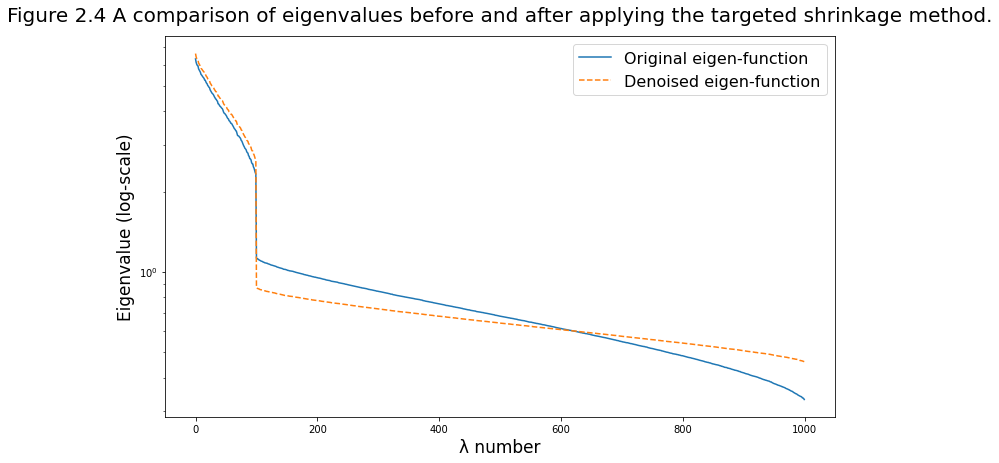

In [57]:
plot_eigen(np.diag(eVal0), np.diag(eVal2), 2.0, 
         title="Figure 2.4 A comparison of eigenvalues before and after applying the targeted shrinkage method.",
        label0="Original eigen-function",
        label1="Denoised eigen-function",
        xlabel="λ number",
        ylabel="Eigenvalue (log-scale)")

### Snippet 2.7 Generating a Block-Diagonal Covariance Matrix and a Vector of Means

In [59]:
def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones((bSize, bSize))*bCorr
    block[range(bSize), range(bSize)] = 1
    corr = block_diag(*([block]*nBlocks))
    return corr

def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    std0 = np.random.uniform(.05,.2,corr0.shape[0])
    cov0 = corr2cov(corr0,std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1,1)
    return mu0,cov0
